In [10]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

%run procedural_stop_words.py

# R package import 
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from statsmodels.stats.multitest import fdrcorrection

R = ro.r
pandas2ri.activate()

quanteda = importr('quanteda')
textstat = importr('quanteda.textstats')

token = R['tokens']
dfm = R['dfm']
grouper = R['dfm_group']
keyness = R['textstat_keyness']

import warnings
warnings.filterwarnings('ignore')

In [2]:
all_df = pd.read_csv('Results/All_speeches_labelled.csv')
all_df = all_df.loc[all_df.party_y != 'I']

In [11]:
def run_jensen_corr(year,topic,binary=True):
    
    # subset year and topic
    sub_df = all_df.loc[(all_df.year_y == year) & (all_df.dynamic_label == topic)]
    
    if len(sub_df) > 0:
        
        # get names of speakers and party
        features = sub_df.groupby('speaker',as_index=False).party_y.first()

        
        # Rpy2 corpus DTM setup
        tokens = token(sub_df['speech_processed'])
        DFM = dfm(tokens)
        grouped = grouper(DFM,groups=sub_df['party_y'])
        
        # Keyness Chi-Square Tests
        Keyness_DF = keyness(grouped,target='R',measure='chi2')
        Keyness_DF['FDR'] = fdrcorrection(Keyness_DF['p'])[0]
        
        # words to remove from correlation analysis
        remove_words = list(Keyness_DF.loc[-Keyness_DF.FDR].feature.values)

        # count terms by speech (min df = 5 for chi-sq)
        vectorizer = CountVectorizer(stop_words=procedural_stop_words + remove_words,binary=binary)
        DTM = vectorizer.fit_transform(sub_df.speech_processed)
        DTM = pd.DataFrame(DTM.toarray())

        terms = vectorizer.get_feature_names() # vocabulary
        
        # sum term occurance by speaker and merge with party
        DTM['speaker'] = list(sub_df['speaker'])
        DTM = (DTM
               .groupby('speaker',as_index=False)
               .sum()
               .merge(features,on='speaker',how='left')
               .drop('speaker',1)
              )
        
        # party labesl for correlation
        party_list = [1 if _ == 'R' else 0 for _ in DTM['party_y']]
        
        # remove non-significant tokens from DTM
        DTM = DTM.drop('party_y',1).to_numpy()
        
        # mean center scale 0,1
        DTM = np.apply_along_axis(lambda x: (x - np.mean(x))/np.std(x),0,DTM)
        
        # correlations pairwise
        corrs = np.apply_along_axis(lambda x: np.corrcoef(x,party_list)[0,1],0,DTM)
        
        partisanship = np.mean(corrs)
        polarization = np.mean(np.abs(corrs))
        
        return {"year":year,
                "topic":topic,
                "partisanship":partisanship,
                'polarization':polarization}



In [18]:
df = []
for topic in tqdm(all_df.dynamic_label.unique()):
    for year in range(1983,2017):
        f = run_jensen_corr(year,topic,binary=False)
        if f:
            df.append(f)

100%|██████████| 63/63 [05:17<00:00,  5.04s/it]


In [20]:
DF = pd.DataFrame(df)

In [23]:
grouped = DF.groupby('year',as_index=False).agg({"partisanship":['mean','std'],'polarization':['mean','std']})

<AxesSubplot:xlabel='year'>

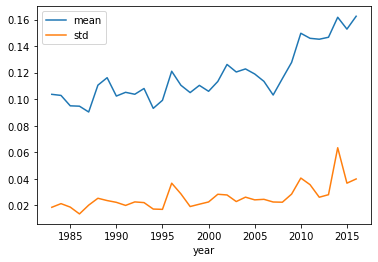

In [24]:
grouped.plot(x='year',y='polarization')

<AxesSubplot:xlabel='year'>

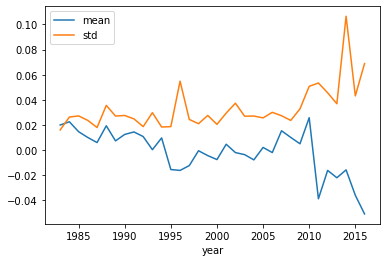

In [25]:
grouped.plot(x='year',y='partisanship')